# Examples of the EMI paper
In this Jupyter notebook are replicated the case studies withthe code and graph from the EMI paper (TODO add DOI).

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from datetime import datetime
import pandas as pd
sys.path.append('../src')
from emagpy import Problem

datadir = 'examples/'
outputdir = 'figures/'

letters = ['a','b','c','d','e','f','g','h','i','j']


## CS vs Maxwell on synthetic conductive models
- Graph 1: homogeneous conductivity increase (X) vs apparent modelled (Y) for CS and FS 
- Graph 2: different height (X) vs apparent modelled (Y) for CS and FS 

In [4]:
# parameters for the synthetic model
coil0 = ['VCP4.49f10000h0']
coil1 = ['VCP4.49f10000h1']

# homogenous ground
condsHomo = np.ones((100,2))*np.arange(100)[:,None]+1
depths = np.ones((100,1))*1

# heterogeneous ground
condsHetero = np.ones((100,2))*np.arange(100)[:,None]+1
condsHetero[:,1] = 50
depths = np.ones((100,1))*0.5

# forward modelling
k0 = Problem()
k0.setModels([depths, depths],[condsHomo, condsHetero])
dfsFSeq0 = k0.forward(forwardModel='FSeq', coils=coil0)
dfsFSlin0 = k0.forward(forwardModel='FSlin', coils=coil0)
dfsCS0 = k0.forward(forwardModel='CS', coils=coil0)

k1 = Problem()
k1.setModels([depths, depths],[condsHomo, condsHetero])
dfsFSeq1 = k1.forward(forwardModel='FSeq', coils=coil1)
dfsFSlin1 = k1.forward(forwardModel='FSlin', coils=coil1)
dfsCS1 = k1.forward(forwardModel='CS', coils=coil1)

Forward modelling
Forward modelling
Forward modelling
Forward modelling
Forward modelling
Forward modelling


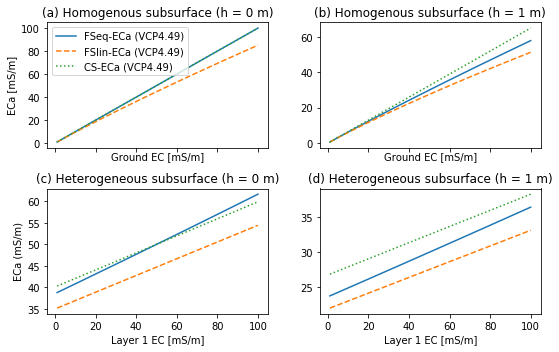

In [5]:
# figure
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(8, 5))
axs = axs.flatten()
ax = axs[0]
ax.set_title('(a) Homogenous subsurface (h = 0 m)')
ax.plot(condsHomo[:,0], dfsFSeq0[0][coil0], '-', label = "FSeq-ECa (VCP4.49)")
ax.plot(condsHomo[:,0], dfsFSlin0[0][coil0], '--', label = "FSlin-ECa (VCP4.49)")
ax.plot(condsHomo[:,0], dfsCS0[0][coil0], ':', label = "CS-ECa (VCP4.49)")
ax.set_ylabel('ECa [mS/m]')
ax.set_xlabel('Ground EC [mS/m]')
ax.legend()

ax = axs[1]
ax.set_title('(b) Homogenous subsurface (h = 1 m)')
ax.plot(condsHomo[:,0], dfsFSeq1[0][coil1], '-', label = "FSeq-ECa (VCP4.49)")
ax.plot(condsHomo[:,0], dfsFSlin1[0][coil1], '--', label = "FSlin-ECa (VCP4.49)")
ax.plot(condsHomo[:,0], dfsCS1[0][coil1], ':', label = "CS-ECa (VCP4.49)")
ax.set_xlabel('Ground EC [mS/m]')

ax = axs[2]
ax.set_title('(c) Heterogeneous subsurface (h = 0 m)')
ax.plot(condsHetero[:,0], dfsFSeq0[1][coil0], '-', label = "FSeq-ECa (VCP4.49)")
ax.plot(condsHetero[:,0], dfsFSlin0[1][coil0], '--', label = "FSlin-ECa (VCP4.49)")
ax.plot(condsHetero[:,0], dfsCS0[1][coil0], ':', label = "CS-ECa (VCP4.49)")
ax.set_ylabel('ECa (mS/m)') 
ax.set_xlabel('Layer 1 EC [mS/m]')

ax = axs[3]
ax.set_title('(d) Heterogeneous subsurface (h = 1 m)')
ax.plot(condsHetero[:,0], dfsFSeq1[1][coil1], '-', label = "FSeq-ECa (VCP4.49)")
ax.plot(condsHetero[:,0], dfsFSlin1[1][coil1], '--', label = "FSlin-ECa (VCP4.49)")
ax.plot(condsHetero[:,0], dfsCS1[1][coil1], ':', label = "CS-ECa (VCP4.49)")
ax.set_xlabel('Layer 1 EC [mS/m]') 

fig.tight_layout()
fig.savefig(outputdir + 'cs-maxwell.jpg', dpi=500)

## CS vs Maxwell on synthetic conductive models
- Graph 1: homogeneous conductivity increase (X) vs apparent modelled (Y) for CS and FS 
- Graph 2: different height (X) vs apparent modelled (Y) for CS and FS

Forward modelling
Forward modelling


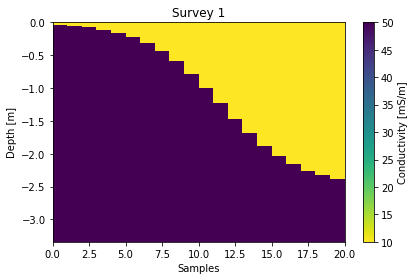

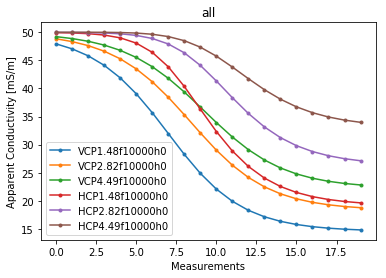

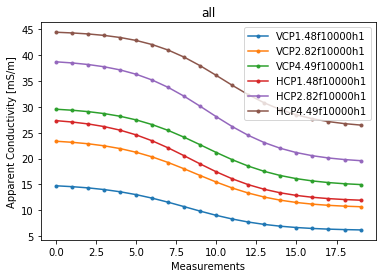

In [6]:
# parameters for the synthetic model
nlayer = 2
npos = 20 # number of positions/sampling location
conds = np.ones((npos, nlayer))*[10, 50]
x = np.linspace(0.1, 2.5, npos)[:,None]
depths = 0 + 2.5/(1+np.exp(-3*(x-1.5)))

coils0 = ['VCP1.48f10000h0', 'VCP2.82f10000h0', 'VCP4.49f10000h0',
          'HCP1.48f10000h0', 'HCP2.82f10000h0', 'HCP4.49f10000h0']
coils1 = ['VCP1.48f10000h1', 'VCP2.82f10000h1', 'VCP4.49f10000h1',
          'HCP1.48f10000h1', 'HCP2.82f10000h1', 'HCP4.49f10000h1']

# 0 m no noise
k0 = Problem()
k0.setModels([depths], [conds])
dfs = k0.forward(forwardModel='FSeq', coils=coils0, noise=0)

# at 1 m no noise
k1 = Problem()
k1.setModels([depths], [conds])
dfs = k1.forward(forwardModel='FSeq', coils=coils1, noise=0)

k0.showResults()
k0.show()
k1.show()

bounds = [(0.01, 3), (0, 80), (0, 80)]
Survey 1/1
20/20 inverted
bounds = [(0.01, 3), (0, 80), (0, 80)]
Survey 1/1
20/20 inverted
bounds = [(0.01, 3), (0, 80), (0, 80)]
Survey 1/1
20/20 inverted
bounds = [(0.01, 3), (0, 80), (0, 80)]
Survey 1/1
20/20 inverted


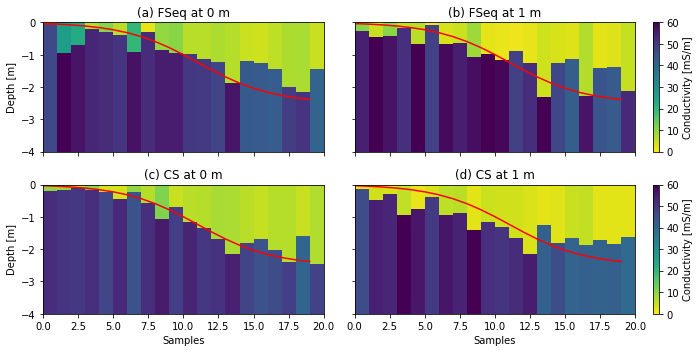

In [7]:
# set initial model for inversion
k0.setInit(depths0=[0.5], fixedDepths=[False])
k1.setInit(depths0=[0.5], fixedDepths=[False])

# figure
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True)
axs = axs.flatten()

ax = axs[0] # FS at 0 m
k0.invert(forwardModel='FSeq', method='ROPE', bnds=[(0.01, 3), (0, 80), (0, 80)], rep=300, njobs=1)
k0.showResults(ax=ax, vmin=0, vmax=60, maxDepth=4)
ax.plot(-depths, 'r-')
fig.axes[-1].remove() # remove colorbar
ax.set_xlabel('')
ax.set_title('(a) FSeq at 0 m')

ax = axs[1] # FS at 1 m
k1.invert(forwardModel='FSeq', method='ROPE', bnds=[(0.01, 3), (0, 80), (0, 80)], rep=300, njobs=1)
k1.showResults(ax=ax, vmin=0, vmax=60, maxDepth=4)
ax.plot(-depths, 'r-')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('(b) FSeq at 1 m')

ax = axs[2] # CS at 0 m
k0.invert(forwardModel='CS', method='ROPE', bnds=[(0.01, 3), (0, 80), (0, 80)], rep=300, njobs=1)
k0.showResults(ax=ax, vmin=0, vmax=60, maxDepth=4)
ax.plot(-depths, 'r-')
fig.axes[-1].remove() # remove colorbar
ax.set_title('(c) CS at 0 m')

ax = axs[3] # CS at 1 m
k1.invert(forwardModel='CS', method='ROPE', bnds=[(0.01, 3), (0, 80), (0, 80)], rep=300, njobs=1)
k1.showResults(ax=ax, vmin=0, vmax=60, maxDepth=4)
ax.plot(-depths, 'r-')
ax.set_ylabel('')
ax.set_title('(d) CS at 1 m')

fig.tight_layout()
fig.savefig(outputdir + 'cs-maxwell-inv.jpg', dpi=500)

## Calibrated and not calibrated ERT with Boxford dataset

In [16]:
#invert ERT data
sys.path.append('../../pyr2/src')
from resipy import R2

kres = R2(datadir + 'boxford-calib/wd') # create an R2 object and set the working directory
kres.createSurvey(datadir + 'boxford-calib/protocol.dat', ftype='Protocol') # read the survey file
kres.elec = np.zeros((96,3))
kres.elec[:,0] = np.arange(0, 96*0.5, 0.5)
kres.createMesh(typ='quad', elemx=2, xgf=2, zf=1.25, zgf=2,doi=4) # generate quadrilateral mesh
kres.param['data_type'] = 1 # use log resisitivity
kres.invert()
#kres.wd = datadir + 'boxford-calib/wd'
#kres.getResults()

Working directory is: /home/pmclachlan/emagpy/src/examples/boxford-calib/wd
clearing the dirname
Inf or NaN: filterData: 0 / 2171 quadrupoles removed.
strange quadrupoles: filterData: 0 / 2171 quadrupoles removed.
2171/2171 reciprocal measurements NOT found.
0 measurements error > 20 %
magErr/phiErr columns detected, will be used in protocol.dat
computed DOI : -6.00
written mesh.dat file to 
/home/pmclachlan/emagpy/src/examples/boxford-calib/wd/mesh.dat
Writing .in file and protocol.dat...
written mesh.dat file to 
/home/pmclachlan/emagpy/src/examples/boxford-calib/wd/mesh.dat
done!

--------------------- MAIN INVERSION ------------------



 >> R  2    R e s i s t i v i t y   I n v e r s i o n   v3.3 <<

 >> D a t e : 10 - 03 - 2020
 >> My beautiful survey
 >> I n v e r s e   S o l u t i o n   S e l e c t e d <<
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading start resistivity from res0.d

Mesh plotted in   0.05 seconds


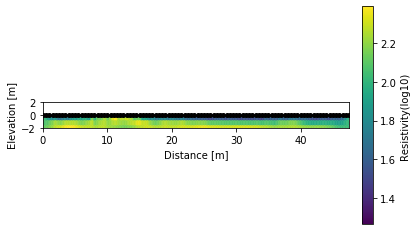

In [15]:
kres.elec[:,0] = np.arange(0, 96*0.5, 0.5)
kres.showResults()


API path =  /media/jkl/data/phd/tmp/pyr2/src/resipy
ResIPy version =  2.0.2
Working directory is: /media/jkl/data/phd/tmp/pyr2/src/resipy/invdir
clearing the dirname
Inf or NaN: filterData: 0 / 2171 quadrupoles removed.
strange quadrupoles: filterData: 0 / 2171 quadrupoles removed.
2171/2171 reciprocal measurements NOT found.
0 measurements error > 20 %
magErr/phiErr columns detected, will be used in protocol.dat
computed DOI : -6.00
[]


IndexError: list index out of range

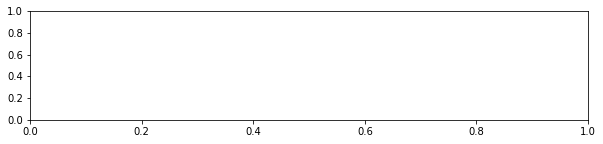

In [2]:
# load inversion results without actually doing the inversion (trick)
k = R2()
k.wd = datadir + 'boxford-calib/wdERT'
k.createSurvey(datadir + 'boxford-calib/protocol.dat', ftype='Protocol')
k.getResults()
print(k.meshResults)
fig, ax = plt.subplots(figsize=(10,2))
k.showResults(ax=ax)

In [7]:
res = np.array(kres.meshResults[0].attr_cache['Resistivity(Ohm-m)'])
kres.meshResults[0].attr_cache['Conductivity(mS/m)'] = 1000/res

IndexError: list index out of range

bounds = [(0.2, 0.8), (0, 10), (8, 25)]
Survey 1/1
43/43 inverted
HCP1.48: ECa(ERT) = 1.64 * ECa(EMI) + -3.87 (R^2=0.70)
HCP2.82: ECa(ERT) = 0.97 * ECa(EMI) + -0.95 (R^2=0.61)
HCP4.49: ECa(ERT) = 0.36 * ECa(EMI) + 3.87 (R^2=0.14)
VCP1.48: ECa(ERT) = 0.98 * ECa(EMI) + 9.28 (R^2=0.27)
VCP2.82: ECa(ERT) = 1.10 * ECa(EMI) + 3.77 (R^2=0.49)
VCP4.49: ECa(ERT) = 1.01 * ECa(EMI) + 1.65 (R^2=0.55)
HCP1.48: ECa(ERT) = 1.64 * ECa(EMI) + -3.87 (R^2=0.70)
HCP2.82: ECa(ERT) = 0.97 * ECa(EMI) + -0.95 (R^2=0.61)
HCP4.49: ECa(ERT) = 0.36 * ECa(EMI) + 3.87 (R^2=0.14)
VCP1.48: ECa(ERT) = 0.98 * ECa(EMI) + 9.28 (R^2=0.27)
VCP2.82: ECa(ERT) = 1.10 * ECa(EMI) + 3.77 (R^2=0.49)
VCP4.49: ECa(ERT) = 1.01 * ECa(EMI) + 1.65 (R^2=0.55)
Correction is applied.
bounds = [(0.2, 0.8), (0, 10), (8, 20)]
Survey 1/1
43/43 inverted


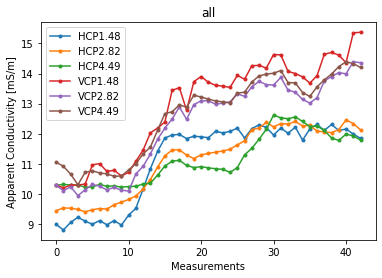

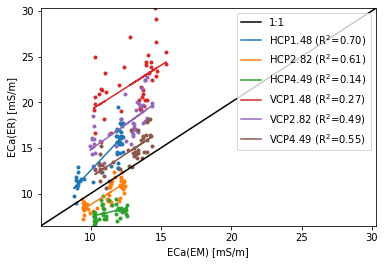

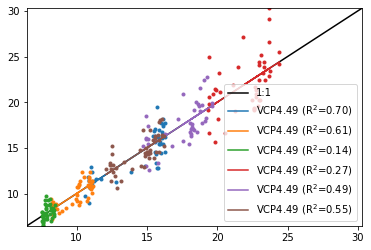

In [20]:
fnameEC = datadir + 'boxford-calib/eri_ec.csv'
fnameECa = datadir + 'boxford-calib/eca_calibration.csv'

# non calibrated
k1 = Problem()
k1.createSurvey(fnameECa)
k1.show()
k1.setInit(depths0=[0.4], fixedDepths=[False], conds0=[5, 15])
k1.invert(forwardModel='CS', method='ROPE', bnds=[(0.2, 0.8), (0, 10), (8, 25)])

# ERT calibrated
k2 = Problem()
k2.createSurvey(fnameECa)
k2.setInit(depths0=[0.4], fixedDepths=[False], conds0=[5, 15])
k2.calibrate(fnameECa, fnameEC, forwardModel='FSeq') # plot calibration
k2.calibrate(fnameECa, fnameEC, forwardModel='FSeq', apply=True) # apply the calibration
k2.invert(forwardModel='CS', method='ROPE', bnds=[(0.2, 0.8), (0, 10), (8, 20)])

HCP1.48: ECa(ERT) = 1.64 * ECa(EMI) + -3.87 (R^2=0.70)
HCP2.82: ECa(ERT) = 0.97 * ECa(EMI) + -0.95 (R^2=0.61)
HCP4.49: ECa(ERT) = 0.36 * ECa(EMI) + 3.87 (R^2=0.14)
VCP1.48: ECa(ERT) = 0.98 * ECa(EMI) + 9.28 (R^2=0.27)
VCP2.82: ECa(ERT) = 1.10 * ECa(EMI) + 3.77 (R^2=0.49)
VCP4.49: ECa(ERT) = 1.01 * ECa(EMI) + 1.65 (R^2=0.55)


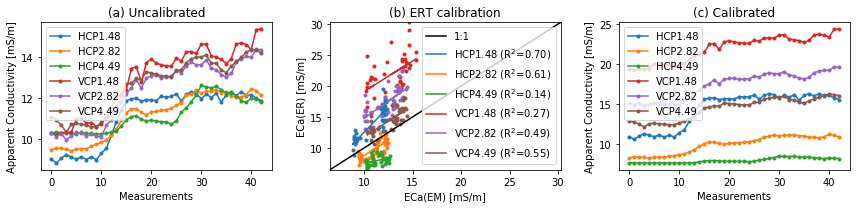

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(12,3))
ax = axs[0]
k1.show(ax=ax)
ax.set_title('(a) Uncalibrated')
ax = axs[1]
ax.set_title('(b) ERT calibration')
k2.calibrate(fnameECa, datadir + 'boxford-calib/eri_ec.csv', forwardModel='FSeq', ax=ax)
ax = axs[2]
k2.show(ax=ax)
ax.set_title('(c) Calibrated')
fig.tight_layout()

Mesh plotted in   0.08 seconds


FileNotFoundError: [Errno 2] No such file or directory: 'figures/calibrated-inv.jpg'

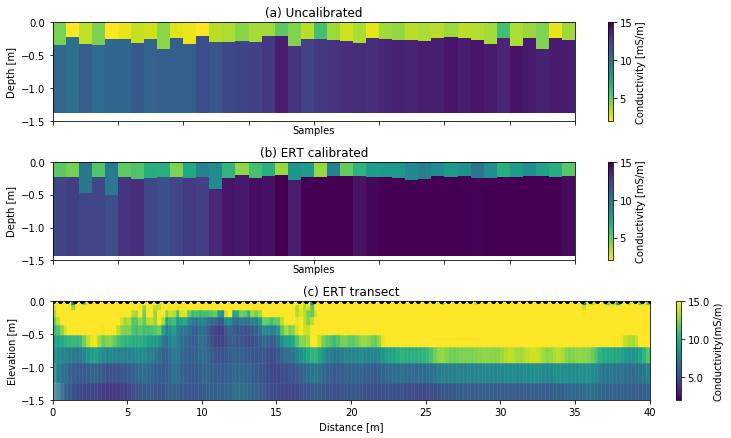

In [23]:
fig, axs = plt.subplots(3, 1, sharey=True, sharex=True, figsize=(10,6))
ax = axs[0]
k1.showResults(ax=ax, vmin=2, vmax=15)
ax.set_title('(a) Uncalibrated')
ax = axs[1]
k2.showResults(ax=ax, vmin=2, vmax=15)
ax.set_title('(b) ERT calibrated')
ax = axs[2]
kres.showResults(ax=ax, contour=False, attr='Conductivity(mS/m)', zlim=[-1.5, 0], vmin=2, vmax=15)
ax.set_title('(c) ERT transect')
ax.set_xlim([0, 40])
ax.set_aspect('auto')
fig.savefig(outputdir + 'calibrated-inv.jpg', dpi=500)

## Sharp and smooth inversions of Devon’s data on saprolite

In [16]:
#TODO bring in explorer data in the inversion
k1 = Problem()
k1.createSurvey(datadir + 'saprolite/mexpl.csv')
k1.setInit(depths0=np.linspace(0.05, 2, 10))
k1.invertGN()

k2 = Problem()
k2.createSurvey(datadir + 'saprolite/mexpl.csv')
k2.setInit(depths0=np.array([0.5]), fixedDepths=[False])
k2.invert(method='ROPE', bnds=[(0.2, 0.7), (10,25), (0, 15)])

Survey 1/1
30/30 inverted
bounds = [(0.2, 0.7), (10, 25), (0, 15)]
Survey 1/1
Starting the ROPE algotrithm with 100 repetitions...
Initialize database...
5 input vectors with 3 parameters
Generating 12 parameters:
(6, 6)
(11, 11)
(16, 16)
2 input vectors with 3 parameters
Generating 12 parameters:
(3, 3)
(5, 5)
(7, 7)
(9, 9)
(11, 11)
(13, 13)
2 input vectors with 3 parameters
Generating 12 parameters:
(3, 3)
(5, 5)
(7, 7)
(9, 9)
(11, 11)
(13, 13)
2 input vectors with 3 parameters
Generating 12 parameters:
(3, 3)
(5, 5)
(7, 7)
(9, 9)
(11, 11)
(13, 13)
End of sampling
Best run at 12 of 100 (best like=-3.36354) with parameter set:
[ 0.27460857 10.87615326  2.89328822]
Duration:0.13 s
1/30 invertedStarting the ROPE algotrithm with 100 repetitions...
Initialize database...
5 input vectors with 3 parameters
Generating 12 parameters:
(6, 6)
(11, 11)
(16, 16)
2 input vectors with 3 parameters
Generating 12 parameters:
(3, 3)
(5, 5)
(7, 7)
(9, 9)
(11, 11)
(13, 13)
2 input vectors with 3 paramet

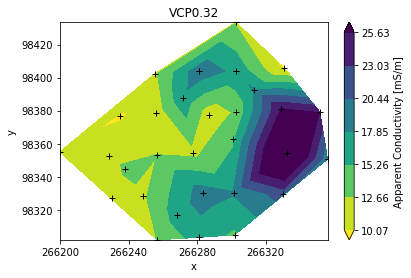

In [17]:
fig, ax = plt.subplots()
k1.showMap(contour=True, pts=True, ax=ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

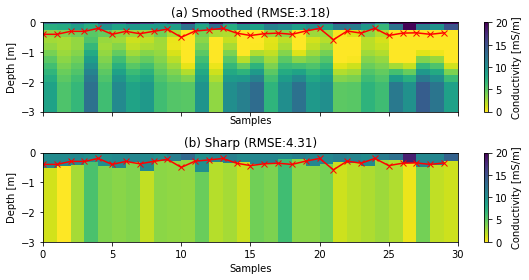

In [21]:
# graph
fig, axs = plt.subplots(2, 1, figsize=(8,4), sharex=True, sharey=True)
ax = axs[0]
k1.showResults(ax=ax, vmin=0, vmax=20, maxDepth=3)
rmse = k1.getRMSE()['all'].values[0]
ax.set_title('(a) Smoothed (RMSE:{:.2f})'.format(rmse))
ax.plot(-k1.surveys[0].df['saproliteDepth'], 'rx-')
ax = axs[1]
k2.showResults(ax=ax, vmin=0, vmax=20, maxDepth=3)
rmse = k2.getRMSE()['all'].values[0]
ax.set_title('(b) Sharp (RMSE:{:.2f})'.format(rmse))
ax.plot(-k1.surveys[0].df['saproliteDepth'], 'rx-')
fig.savefig(outputdir + 'smooth-sharp.jpg', dpi=500)

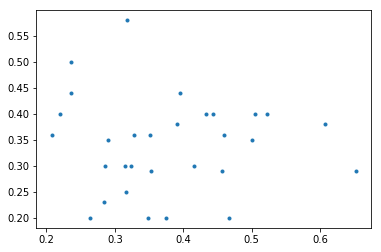

In [22]:
fig, ax = plt.subplots()
ax.plot(k2.depths[0][:,0], k2.surveys[0].df['saproliteDepth'], '.')

## Effect of noise and height on the inversion - Guillaume
- Similar to Paul’s thesis graph: adding noise make the inversion less reliable 
- Graph with increasing noise level on a 2D model ? 

Forward modelling
Forward modelling
Forward modelling
Forward modelling


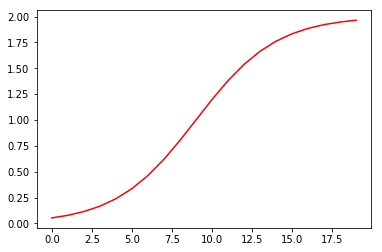

In [9]:
# parameters for the synthetic model
nlayer = 2
npos = 20
conds = np.ones((npos, nlayer))*[20, 100]
x = np.linspace(0.1, 2, npos)[:,None]
depths = 0 + 2/(1+np.exp(-4*(x-1)))
fig, ax = plt.subplots()
ax.plot(depths, 'r-')
fig.show()

#coils0 = ['VCP0.32', 'VCP0.71', 'VCP1.18', 'HCP0.32', 'HCP0.71', 'HCP1.18']
#coils1 = ['VCP0.32f30000h1', 'VCP0.71f30000h1', 'VCP1.18f30000h1',
#         'HCP0.32f30000h1', 'HCP0.71f30000h1', 'HCP1.18f30000h1']
coils0 = ['VCP1.48f10000h0', 'VCP2.82f10000h0', 'VCP4.49f10000h0',
          'HCP1.48f10000h0', 'HCP2.82f10000h0', 'HCP4.49f10000h0']
coils1 = ['VCP1.48f10000h1', 'VCP2.82f10000h1', 'VCP4.49f10000h1',
          'HCP1.48f10000h1', 'HCP2.82f10000h1', 'HCP4.49f10000h1']
titles = ['at 0 m (no noise)', 'at 0 m (with 5% noise)',
          'at 1 m (no noise)', 'at 1 m (with 5% noise)']

# 0 m no noise
k1 = Problem()
k1.setModels([depths], [conds])
dfs = k1.forward(forwardModel='FSeq', coils=coils0, noise=0)

# at 0 m with noise
k2 = Problem()
k2.setModels([depths], [conds])
dfs = k2.forward(forwardModel='FSeq', coils=coils0, noise=0.05)

# 1 m no noise
k3 = Problem()
k3.setModels([depths], [conds])
dfs = k3.forward(forwardModel='FSeq', coils=coils1, noise=0)

# at 1 m with noise
k4 = Problem()
k4.setModels([depths], [conds])
dfs = k4.forward(forwardModel='FSeq', coils=coils1, noise=0.05)

ks = [k1, k2, k3, k4]

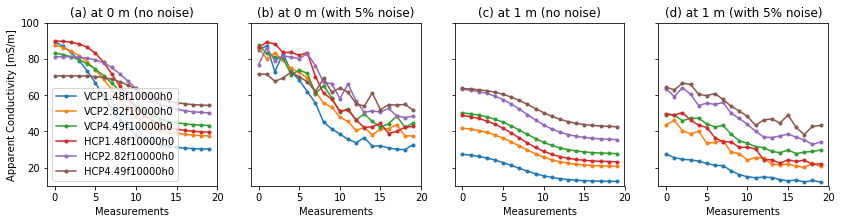

In [3]:
# graph of apparent values
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(14,3))
for i in range(4):
    ax = axs[i]
    ks[i].show(ax=ax, vmin=10, vmax=100)
    ax.set_title('({:s}) {:s}'.format(letters[i], titles[i]))
    if i > 0:
        ax.get_legend().remove()
        ax.set_ylabel('')

In [12]:
# invert
for k in ks:
    k.setInit(depths0=np.array([0.5]), fixedDepths=[False])
    k.invert(method='ROPE', bnds=[(0.1, 3), (10, 30), (80, 120)], rep=200, njobs=-1)

#    k.setInit(depths0=np.linspace(0.1, 5, 20))
#    k.invertGN()
    
#    k.setInit(depths0=np.array([0.5, 1]))
#    k.invert(fixedDepths=False)

bounds = [(0.1, 3), (10, 30), (80, 120)]
Survey 1/1
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
20/20 inverted
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    7.1s finished
bounds = [(0.1, 3), (10, 30), (80, 120)]
Survey 1/1
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
20/20 inverted
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.4s finished
bounds = [(0.1, 3), (10, 30), (80, 120)]
Survey 1/1
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
20/20 inverted
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.5s finished
bounds = [(0.1, 3), (10, 30), (80, 120)]
Survey 1/1
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
20/20 inverted
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.9s finished


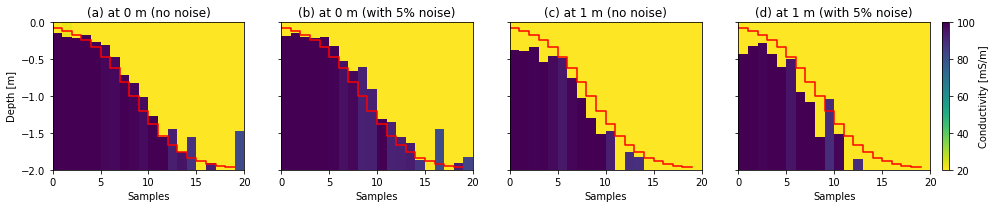

In [13]:
# graph of inverted values
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(14,3))
for i in range(4):
    ax = axs[i]
    ks[i].showResults(ax=ax, vmin=20, vmax=100, maxDepth=2)
    ax.set_title('({:s}) {:s}'.format(letters[i], titles[i]))
    ax.step(np.arange(depths.shape[0]), -depths, 'r') # true depth
    if i < 3:
        fig.axes[-1].remove()
    if i > 0:
        ax.set_ylabel('')
fig.savefig(outputdir + 'inv-noise.jpg', dpi=500)

In [17]:
# graph noise level vs RMSE of predicted depth (takes a long time)
noises = np.linspace(0, 0.1, 10)
def computeRMSE(x, y):
    return np.sqrt(np.sum((x - y)**2)/len(x))
dfrmse = pd.DataFrame(noises, columns=['noise'])
dfrmse['h0'] = np.nan
dfrmse['h1'] = np.nan
for i, coils in zip(['h0','h1'], [coils0, coils1]):
    tmp = []
    for j, noise in enumerate(noises):
        k = Problem()
        k.models = [conds]
        k.depths = [depths]
        dfs = k.forward(forwardModel='FS', coils=coils, noise=noise)
        k.setInit(depths0=np.array([0.5]), fixedDepths=[False])
        k.invert(method='ROPE', bnds=[(10, 30), (80, 120), (0.1, 3)])
#        k.invert(fixedDepths=False)
        dfrmse.loc[j, i] = computeRMSE(depths, k.depths[0].flatten())
        print(dfrmse)

Forward modelling
bounds chosen: [(10, 30), (80, 120), (0.1, 3)]
Survey 1/1

Starting the ROPE algotrithm with 100 repetitions...
Initialize database...
* Database file 'invertSCEUA.csv' created.
5 input vectors with 3 parameters
Generating 12 parameters:
(6, 6)
(11, 11)
(16, 16)
2 input vectors with 3 parameters
Generating 12 parameters:
(3, 3)
(5, 5)
(7, 7)
(9, 9)
(11, 11)
(13, 13)
2 input vectors with 3 parameters
Generating 12 parameters:
(3, 3)
(5, 5)
(7, 7)
(9, 9)
(11, 11)
(13, 13)
2 input vectors with 3 parameters
Generating 12 parameters:
(3, 3)
(5, 5)
(7, 7)
(9, 9)
(11, 11)
(13, 13)
End of sampling
Best run at 29 of 100 (best like=-7.8853) with parameter set:
[22.00955933 88.39097123  0.15770052]
Duration:0.18 s
1/20 inverted (ok)
Starting the ROPE algotrithm with 100 repetitions...
Initialize database...
* Database file 'invertSCEUA.csv' created.
5 input vectors with 3 parameters
Generating 12 parameters:
(6, 6)
(11, 11)
(16, 16)
2 input vectors with 3 parameters
Generating 1

Text(0, 0.5, 'RMSE of depth [m]')

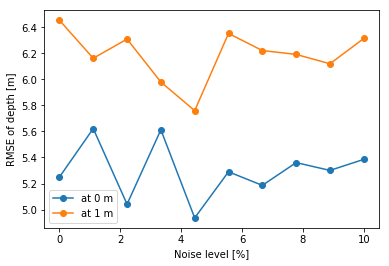

In [18]:
fig, ax = plt.subplots()
ax.plot(dfrmse['noise']*100, dfrmse['h0'], 'o-', label='at 0 m')
ax.plot(dfrmse['noise']*100, dfrmse['h1'], 'o-', label='at 1 m')
ax.legend()
ax.set_xlabel('Noise level [%]')
ax.set_ylabel('RMSE of depth [m]')

### Obervations
- Increasing the depth of 1 m above the ground make it much more difficult to define the boundary between the layers. Even more when the noise level of the measurements increase.
- at 1 m is always worse but there is no substantial increase of RMSE with noise level

## Time-lapse field application - Guillaume 
- Soil moisture content evolution vs EMI timelapse inversion 
- Quebec data, warren data or synthetic 

In [14]:
fnames = [
        datadir + 'timelapse-wheat/170316.csv',
        datadir + 'timelapse-wheat/170403.csv',
        datadir + 'timelapse-wheat/170427.csv',
        datadir + 'timelapse-wheat/170516.csv',
        ]

k = Problem()
k.createTimeLapseSurvey(fnames)
# just look at a few measurements for better graph
for s in k.surveys:
    s.df = s.df[:30]
    s.name = datetime.strptime('20' + s.name, '%Y%m%d').strftime('%Y-%m-%d')

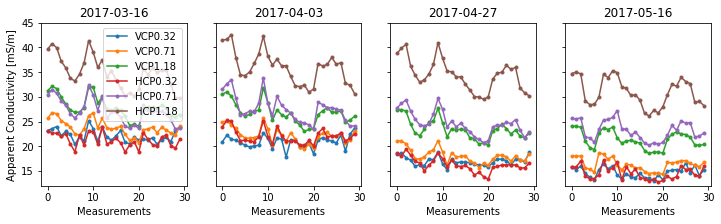

In [15]:
# graph of apparent conductivities
fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharex=True, sharey=True)
axs = axs.flatten()
for i, s in enumerate(k.surveys):
    ax = axs[i]
    k.show(i, ax=ax, vmin=12, vmax=45)
    ax.set_title(s.name)
    if i > 0:
        ax.set_ylabel('')
        ax.get_legend().remove()

In [16]:
# absolute inversion
#k.invert()
k.setInit(depths0=np.linspace(0.1, 2, 20))
k.invertGN()
#k.invertMCMC(fixedDepths=False)

Survey 1/4
30 measurements inverted
Survey 2/4
30 measurements inverted
Survey 3/4
30 measurements inverted
Survey 4/4
30 measurements inverted


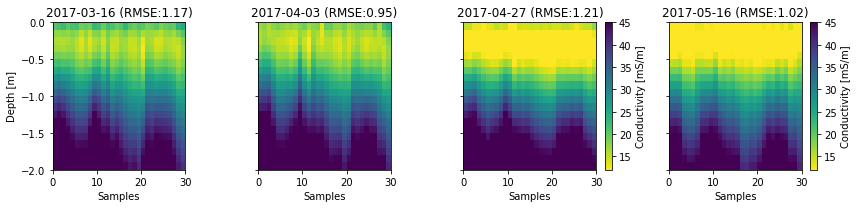

In [17]:
# graph of inverted conductivities
rmse = k.getRMSE()
fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharex=True, sharey=True)
axs = axs.flatten()
for i, s in enumerate(k.surveys):
    ax = axs[i]
    k.showResults(i, ax=ax, vmin=12, vmax=45, maxDepth=2)
    ax.set_title('{:s} (RMSE:{:.2f})'.format(s.name, rmse['all'].values[i]))
    if i < 2:
        fig.axes[-1].remove()
    if i > 0:
        ax.set_ylabel('')

In [13]:
# absolute inversion
k.setInit(depths0=np.array([0.7]), fixedDepths=[False])
k.invert(method='ROPE')

bounds = [(0.2, 0.8999999999999999), (2.0, 100.0), (2.0, 100.0)]
Survey 1/4
30 measurements inverted (0 converged)
Survey 2/4
30 measurements inverted (0 converged)
Survey 3/4
30 measurements inverted (0 converged)
Survey 4/4
30 measurements inverted (0 converged)


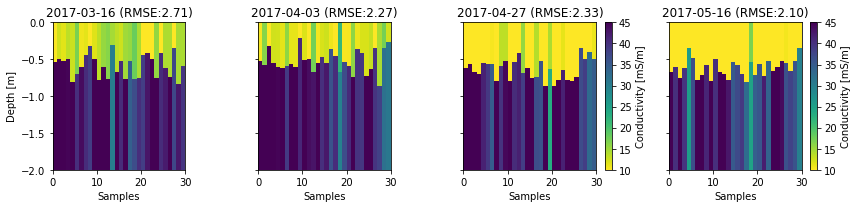

In [14]:
# graph of inverted conductivities
rmse = k.getRMSE()
fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharex=True, sharey=True)
for i, s in enumerate(k.surveys):
    ax = axs[i]
    k.showResults(i, ax=ax, vmin=10, vmax=45, maxDepth=2)
    ax.set_title('{:s} (RMSE:{:.2f})'.format(s.name, rmse['all'].values[i]))
    if i < 2:
        fig.axes[-1].remove()
    if i > 0:
        ax.set_ylabel('')

In [18]:
# inversion of change
k = Problem()
k.createTimeLapseSurvey(fnames)
for s in k.surveys:
    s.df = s.df[:30]
    s.name = datetime.strptime('20' + s.name, '%Y%m%d').strftime('%Y-%m-%d')
k.setInit(depths0=np.linspace(0.1, 2, 20))
#k.setInit(depths0=np.array([0.3, 0.7]))
k.computeApparentChange()
#k.invert(beta=0.1)
k.invertGN()

Trimming surveys and only keep common positions
Matching positions between surveys for time-lapse inversion...30 in common...done in 0.0297s
Computing relative ECa compared to background (1st survey).
Survey 1/4
30 measurements inverted
Survey 2/4
30 measurements inverted
Survey 3/4
30 measurements inverted
Survey 4/4
30 measurements inverted


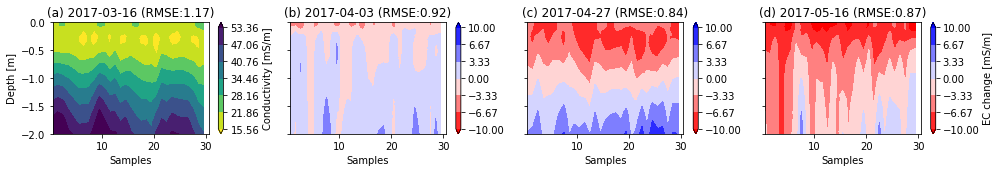

In [19]:
# graph of inverted conductivities change relative to background
rmse = k.getRMSE()

fig, axs = plt.subplots(1, 4, figsize=(14, 2.5), sharex=True, sharey=True)
axs = axs.flatten()
for i, s in enumerate(k.surveys):
    ax = axs[i]
    if i == 0:
        k.showResults(i, ax=ax, contour=True, maxDepth=2)
    else:
        k.showResults(i, ax=ax, vmin=-10, vmax=10, cmap='bwr_r', contour=True, maxDepth=2)
    ax.set_title('({:s}) {:s} (RMSE:{:.2f})'.format(letters[i], s.name, rmse['all'].values[i]))
    if i < 3:
        pass
        #fig.axes[-1].remove()
    else:
        fig.axes[-1].set_ylabel('EC change [mS/m]')
    if i > 0:
        ax.set_ylabel('')
        if i != 3:
            fig.axes[-1].set_ylabel('')
fig.tight_layout()
fig.savefig(outputdir + 'inv-timelapse.jpg', dpi=500)

## Different types of inversions

In [16]:
# Gauss-Newton
k1 = Problem()
k1.createSurvey(datadir + 'cover-crop/coverCrop.csv')
k1.setInit(depths0=np.linspace(0.1, 2, 20))
k1.surveys[0].df = k1.surveys[0].df[:20]
k1.invertGN()

# Minimize
k2 = Problem()
k2.createSurvey(datadir + 'cover-crop/coverCrop.csv')
k2.setInit(depths0=np.array([0.3, 0.7]), fixedDepths=[True, True])
k2.surveys[0].df = k2.surveys[0].df[:20]
k2.invert(method='L-BFGS-B')

# MCMC
k3 = Problem()
k3.createSurvey(datadir + 'cover-crop/coverCrop.csv')
k3.setInit(depths0=np.array([0.7]), fixedDepths=[False])
k3.surveys[0].df = k3.surveys[0].df[:20]
k3.invert(method='ROPE')

ks = [k1, k2, k3]

Survey 1/1
20 measurements inverted
bounds =  None
Survey 1/1
20 measurements inverted (20 converged)
bounds =  [(0.2, 0.8999999999999999), (2.0, 100.0), (2.0, 100.0)]
Survey 1/1
Starting the ROPE algotrithm with 100 repetitions...
Initialize database...
* Database file 'db.csv' created.
5 input vectors with 3 parameters
Generating 12 parameters:
(6, 6)
(11, 11)
(16, 16)
2 input vectors with 3 parameters
Generating 12 parameters:
(3, 3)
(5, 5)
(7, 7)
(9, 9)
(11, 11)
(13, 13)
2 input vectors with 3 parameters
Generating 12 parameters:
(3, 3)
(5, 5)
(7, 7)
(9, 9)
(11, 11)
(13, 13)
2 input vectors with 3 parameters
Generating 12 parameters:
(3, 3)
(5, 5)
(7, 7)
(9, 9)
(11, 11)
(13, 13)
End of sampling
Best run at 70 of 100 (best like=-1.01107) with parameter set:
[ 0.82850937 29.29564016 56.98008172]
Duration:0.18 s
1/20 inverted (ok)Starting the ROPE algotrithm with 100 repetitions...
Initialize database...
* Database file 'db.csv' created.
5 input vectors with 3 parameters
Generating 12

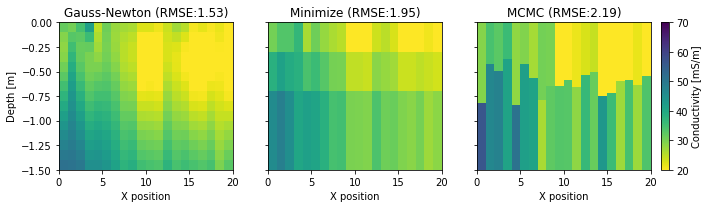

In [18]:
# graph
methods = ['Gauss-Newton', 'Minimize', 'MCMC'] # TODO put exact names
fig, axs = plt.subplots(1, 3, figsize=(10,3), sharex=True, sharey=True)
for i, k in enumerate(ks):
    ax = axs[i]
    k.showResults(ax=ax, vmin=20, vmax=70, maxDepth=1.5)
    if i < 2:
        fig.axes[-1].remove()
    if i > 0:
        ax.set_ylabel('')
    rmse = k.getRMSE()
    ax.set_title('{:s} (RMSE:{:.2f})'.format(methods[i], rmse['all'].values[0]))
fig.savefig(outputdir + 'inversion-types.jpg', dpi=500)

number of nan 0 0
number of nan 0 0
number of nan 0 0


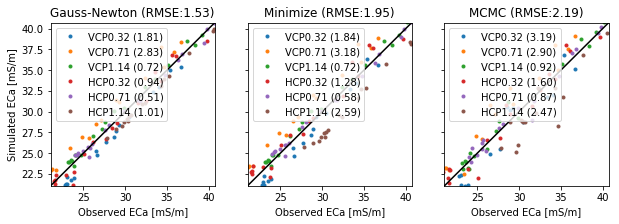

In [19]:
# graph of one2one
fig, axs = plt.subplots(1, 3, figsize=(10,3), sharex=True, sharey=True)
for i, k in enumerate(ks):
    ax = axs[i]
    k.showOne2one(ax=ax)
    if i > 0:
        ax.set_ylabel('')
    rmse = k.getRMSE()
    ax.set_title('{:s} (RMSE:{:.2f})'.format(methods[i], rmse['all'].values[0]))

## Capabilities of EMagPy

Forward modelling
Deleted 13/60 measurements
dataset shrunk of 2 measurements
VCP0.71 0.53 * x + 2.34 (R=0.54)
HCP0.71 0.22 * x + 10.44 (R=0.22)
Transformation to LIN ECa for CMD Mini-Explorer at F-0m calibration
found 766 / 3792 crossing points
bounds = None
Survey 1/1
45 measurements inverted (0 converged)


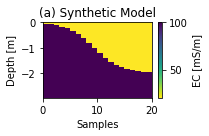

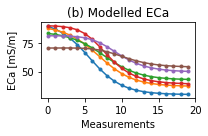

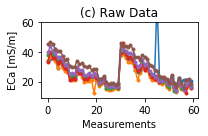

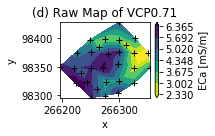

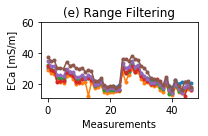

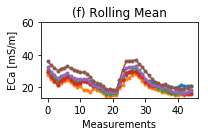

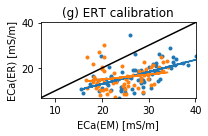

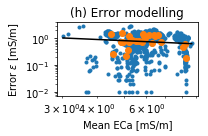

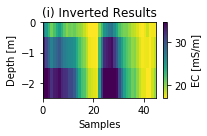

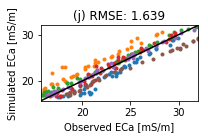

In [12]:
figsize = (3,2)

# forward modelling
nlayer = 2
npos = 20
conds = np.ones((npos, nlayer))*[20, 100]
x = np.linspace(0.1, 2, npos)[:,None]
depths = 0 + 2/(1+np.exp(-4*(x-1)))
coils0 = ['VCP1.48f10000h0', 'VCP2.82f10000h0', 'VCP4.49f10000h0',
          'HCP1.48f10000h0', 'HCP2.82f10000h0', 'HCP4.49f10000h0']
k = Problem()
k.setModels([depths], [conds])
dfs = k.forward(forwardModel='FS', coils=coils0, noise=0)

fig, ax = plt.subplots(figsize=figsize)
k.showResults(ax=ax)
ax.set_title('(a) Synthetic Model')
fig.axes[-1].set_ylabel('EC [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-forward-model.jpg')

fig, ax = plt.subplots(figsize=figsize)
k.show(ax=ax)
ax.get_legend().remove()
ax.set_title('(b) Modelled ECa')
ax.set_ylabel('ECa [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-forward-show.jpg')


# create EMI model
k = Problem()
k.createSurvey(datadir + 'cover-crop/coverCrop.csv')
k.surveys[0].df = k.surveys[0].df[:60]
#k.coils = k.coils[:3] # just VCP
#k.surveys[0].coils = k.surveys[0].coils[:3]

# data display
fig, ax = plt.subplots(figsize=figsize)
k.show(ax=ax, vmax=60)
ax.get_legend().remove()
ax.set_title('(c) Raw Data')
ax.set_ylabel('ECa [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-show.jpg')

# data map
fig, ax = plt.subplots(figsize=figsize)
k2 = Problem()
k2.createSurvey(datadir + 'saprolite/regolith.csv')
k2.convertFromNMEA()
k2.showMap(coil=k2.coils[1], ax=ax, contour=True, pts=True)
ax.set_title('(d) Raw Map of VCP0.71')
fig.axes[-1].set_ylabel('ECa [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-showMap.jpg')

# filter range
fig, ax = plt.subplots(figsize=figsize)
k.filterRange(vmin=10, vmax=40)
k.show(ax=ax, vmax=60)
ax.get_legend().remove()
ax.set_title('(e) Range Filtering')
ax.set_ylabel('ECa [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-filterRange.jpg')

# filter pick
#fig, ax = plt.subplots()
#k.show(ax=ax, vmax=60)
#fig.savefig(outputdir + 'cap-filterPick.jpg')

# filter smooth
fig, ax = plt.subplots(figsize=figsize)
k.rollingMean()
k.show(ax=ax, vmax=60)
ax.set_title('(f) Rolling Mean')
ax.get_legend().remove()
ax.set_ylabel('ECa [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-smooth.jpg')

# ERT calibration
fig, ax = plt.subplots(figsize=figsize)
k.calibrate(datadir + 'calib/dfeca2.csv', datadir + 'calib/dfec.csv', ax=ax)
ax.get_legend().remove()
ax.set_title('(g) ERT calibration')
fig.tight_layout()
fig.savefig(outputdir + 'cap-calib.jpg')

# EMI error modelling
k2 = Problem() # need other dataset as cover-crop doesn't have cross-over points
k2.importGF(fnameLo = datadir + 'potatoes/potatoesLo.dat')
k2.convertFromNMEA()
fig, ax = plt.subplots(figsize=figsize)
k2.crossOverPoints(ax=ax, coil=k.coils[1])
ax.set_title('(h) Error modelling')
ax.get_legend().remove()
ax.set_xlabel('Mean ECa [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-error.jpg')

# Inverse results
fig, ax = plt.subplots(figsize=figsize)
k.invert()
k.showResults(ax=ax, contour=False)
ax.set_title('(i) Inverted Results')
fig.axes[-1].set_ylabel('EC [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-showResults.jpg')

# Inverse quality
fig, ax = plt.subplots(figsize=figsize)
k.showOne2one(ax=ax)
ax.get_legend().remove()
ax.set_title('(j) ' + ax.get_title())
fig.tight_layout()
fig.savefig(outputdir + 'cap-one2one.jpg')

(20, 2)
(20, 3)


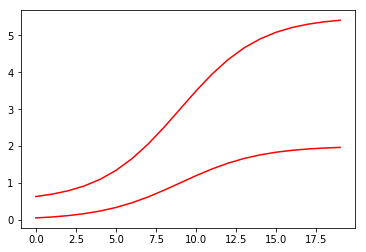

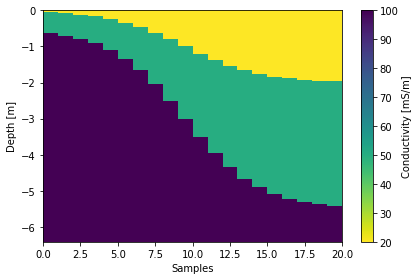

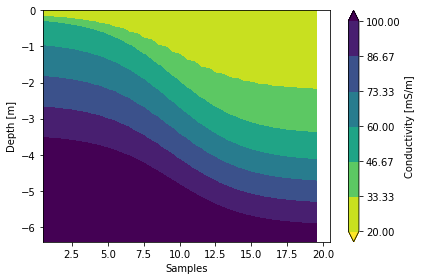

In [25]:
# illustrative graph for figure 3
nlayer = 3
npos = 20
conds = np.ones((npos, nlayer))*[20, 50, 100]
x = np.linspace(0.1, 2, npos)[:,None]
depth1 = 0 + 2/(1+np.exp(-4*(x-1)))
depth2 = 0.5 + 5/(1+np.exp(-4*(x-1)))
depths = np.c_[depth1, depth2]
fig, ax = plt.subplots()
ax.plot(depths, 'r-')
fig.show()
print(depths.shape)
print(conds.shape)
k = Problem()
k.setModels([depths], [conds])
k.showResults()
k.showResults(contour=True)